In [1]:
import pandas as pd

URL = (
    "https://data.enseignementsup-recherche.gouv.fr/"
    "api/explore/v2.0/catalog/datasets/fr-esr-cartographie_formations_parcoursup/exports/csv"
    "?lang=fr&timezone=UTC"
)

# Lecture directe du CSV compressé
df = pd.read_csv(URL, sep=';')

print(df.head())
print(df.shape)

   annee  etab_uai                                           etab_nom  \
0   2025  0381629P                               CNED (Grenoble - 38)   
1   2025  0690276A                CNED (Lyon 4e  Arrondissement - 69)   
2   2025  0861273S                  CNED (Chasseneuil-du-Poitou - 86)   
3   2025  0861273S                  CNED (Chasseneuil-du-Poitou - 86)   
4   2025  0720033V  Lycée Polyvalent Gabriel Touchard - Washington...   

        tc                 tf  \
0  Publics  BTS - BTSA - BTSM   
1  Publics  BTS - BTSA - BTSM   
2  Publics  BTS - BTSA - BTSM   
3  Publics  BTS - BTSA - BTSM   
4  Publics  BTS - BTSA - BTSM   

                                                  nm  \
0  BTS - Services - Tourisme - Entièrement en dis...   
1  BTS - Services - Support à l'action managérial...   
2  BTS - Services - Collaborateur juriste notaria...   
3  BTS - Services - Services informatiques aux or...   
4  BTS - Production - Conception de produits indu...   

                         

/tmp/ipykernel_16124/2053205252.py:10: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(URL, sep=';')


Nombre de formations très sélectives (top 5% en pression) : 545
     Session  \
10      2024   
178     2024   
184     2024   
197     2024   
226     2024   

    Statut de l’établissement de la filière de formation (public, privé…)  \
10                                              Public                      
178                       Privé enseignement supérieur                      
184                       Privé enseignement supérieur                      
197                                             Public                      
226                                 Privé hors contrat                      

    Code UAI de l'établissement  \
10                     0941111X   
178                    0941934S   
184                    0101059X   
197                    0631383L   
226                    0142440B   

                                              etab_nom  \
10   Université Paris- Est-Créteil Val de Marne - U...   
178                                        EFREI 

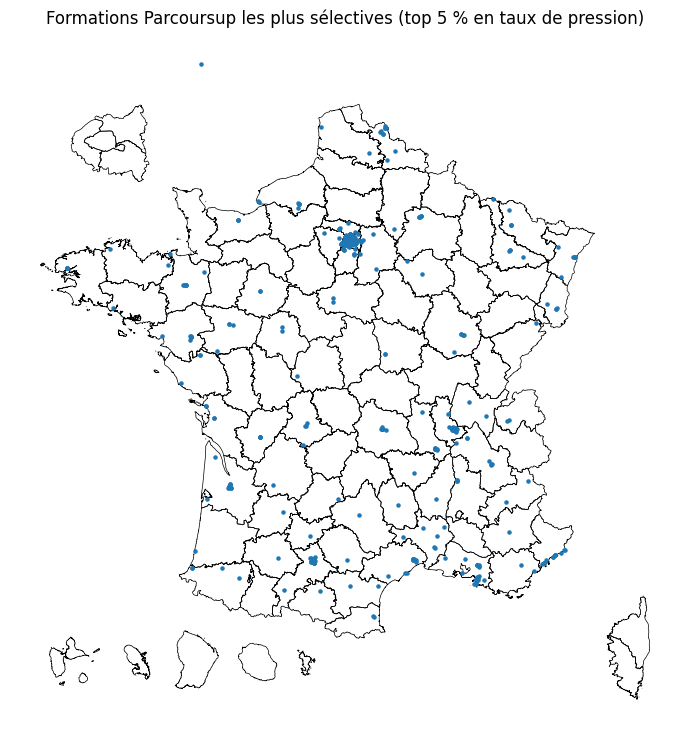

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# 1) Charger les stats Parcoursup
url_stats = (
    "https://data.enseignementsup-recherche.gouv.fr/"
    "explore/dataset/fr-esr-parcoursup/download/"
    "?format=csv&timezone=Europe/Berlin&lang=fr"
    "&use_labels_for_header=true&csv_separator=%3B"
)

df_stats_raw = pd.read_csv(url_stats, sep=";")

# 2) Renommer les colonnes importantes
df_stats = df_stats_raw.rename(columns={
    "Filière de formation": "Filière",
    "Établissement": "etab_nom",
    "Département de l’établissement": "departement",
    "Académie de l’établissement": "academie",
    "Commune de l’établissement": "commune",
    "Sélectivité": "Sélectivité",
    "Effectif total des candidats pour une formation": "Effectif_candidats",
    "Capacité de l’établissement par formation": "Capacite",
    "Coordonnées GPS de la formation": "gps"
})

# 3) Nettoyer les variables numériques et calculer le taux de pression
df_stats["Capacite"] = pd.to_numeric(df_stats["Capacite"], errors="coerce")
df_stats["Effectif_candidats"] = pd.to_numeric(df_stats["Effectif_candidats"], errors="coerce")

df_stats_clean = df_stats[
    df_stats["Capacite"].notna() &
    (df_stats["Capacite"] > 0) &
    df_stats["Effectif_candidats"].notna()
].copy()

df_stats_clean["taux_pression"] = df_stats_clean["Effectif_candidats"] / df_stats_clean["Capacite"]

# 4) Filtrer sur les formations sélectives et garder le top 5 % en pression
df_sel = df_stats_clean[df_stats_clean["Sélectivité"] == "formation sélective"].copy()

seuil = df_sel["taux_pression"].quantile(0.95)
df_top = df_sel[df_sel["taux_pression"] >= seuil].copy()

print("Nombre de formations très sélectives (top 5% en pression) :", len(df_top))

# 5) Transformer en GeoDataFrame
df_top_geo = df_top.dropna(subset=["gps"]).copy()

df_top_geo[["lat", "lon"]] = (
    df_top_geo["gps"]
    .astype(str)
    .str.split(",", expand=True)
    .apply(lambda s: s.str.strip())
    .astype(float)
)

gdf_top = gpd.GeoDataFrame(
    df_top_geo,
    geometry=gpd.points_from_xy(df_top_geo["lon"], df_top_geo["lat"]),
    crs="EPSG:4326"
)

print(gdf_top.head())

# 6) Fond de carte + carte des formations les plus sélectives
fr_departements = carti_download(
    values=["France"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Métropole uniquement (bbox grossière)
gdf_top_metro = gdf_top.cx[-6:10, 41:52].copy()

fig, ax = plt.subplots(figsize=(7, 9))

fr_departements.plot(
    ax=ax,
    linewidth=0.5,
    edgecolor="black",
    facecolor="none"
)

gdf_top_metro.plot(
    ax=ax,
    markersize=5
)

ax.set_title("Formations Parcoursup les plus sélectives (top 5 % en taux de pression)")
ax.set_axis_off()
plt.tight_layout()
